### Training VGG-16 model with K-Fold Validation

Found 480 images belonging to 4 classes.
Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.2756 - loss: 1.4221 - val_accuracy: 0.4375 - val_loss: 1.2576 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.4146 - loss: 1.2840 - val_accuracy: 0.4792 - val_loss: 1.0965 - learning_rate: 0.0010
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.5437 - loss: 1.0689 - val_accuracy: 0.6458 - val_loss: 0.9474 - learning_rate: 0.0010
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.5708 - loss: 1.0217 - val_accuracy: 0.6771 - val_loss: 0.7985 - learning_rate: 0.0010
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.6753 - loss: 0.8571 - val_accuracy: 0.7500 - val_loss: 0.7055 - learning_rate: 0.0010
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.6830 - loss: 0.7495 - val_accuracy: 0.7292 - val_loss: 0.6676 - learning_rate: 0.0010
Epoch

Validation loss: 0.4926
Validation accuracy: 0.8438


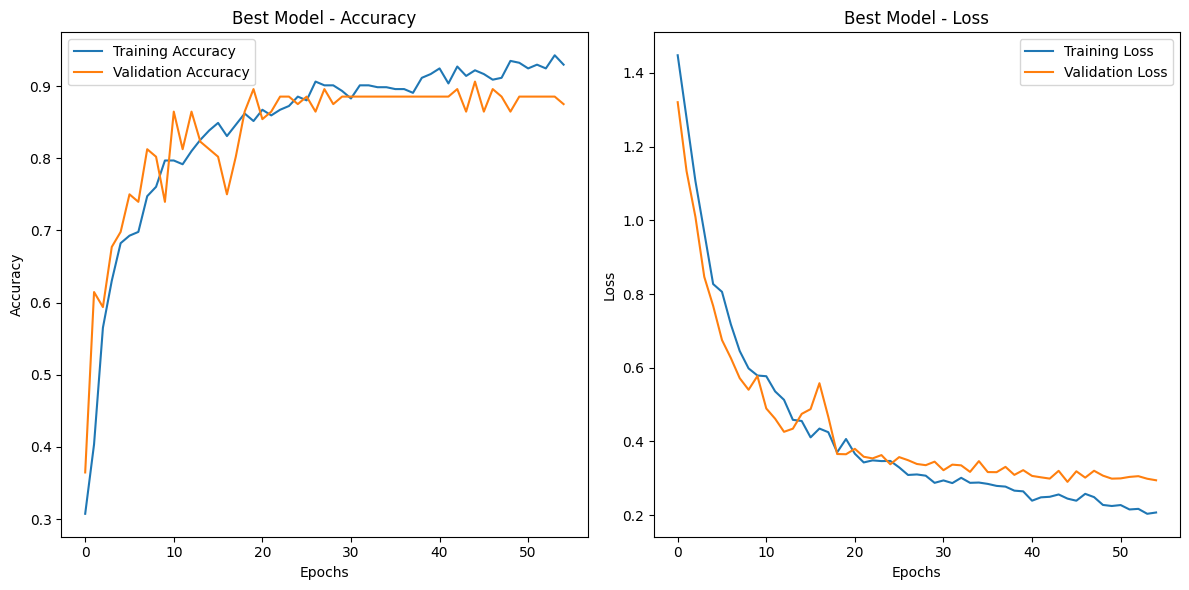

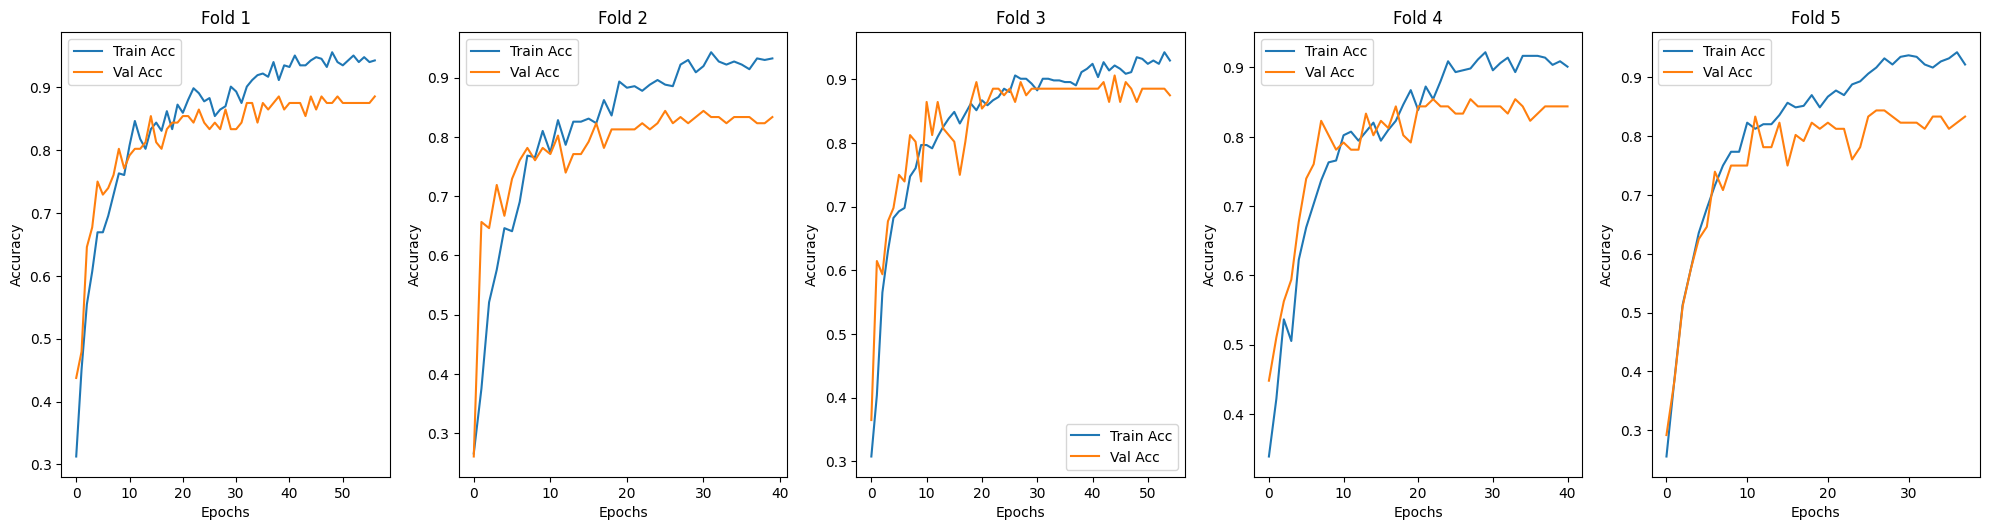

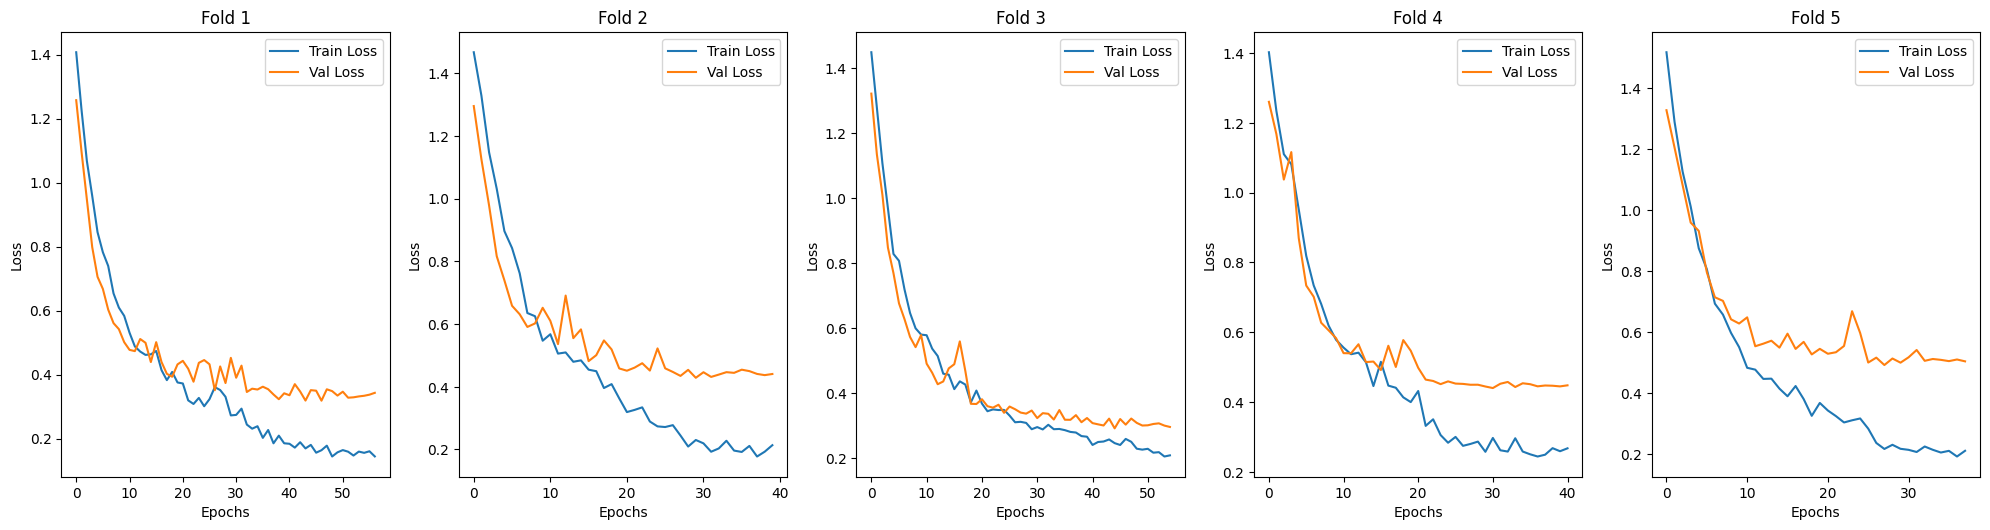

In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold

# Path to your original dataset
data_dir = 'dataset_9'

IMG_DIM = 256
batch_size = 32

# Define custom preprocessing function
def preprocess_input(image):
    image = image / 255.0  # Normalizing the image
    return image

# Data augmentation for training
datagen = ImageDataGenerator(
    rescale=1./255
)

# Load the data from directory
data_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_DIM, IMG_DIM),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb',
)

# Calculate class weights
classes = list(data_gen.class_indices.keys())
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(data_gen.classes),
    y=data_gen.classes
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class weights: {class_weights}")

def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_DIM, IMG_DIM, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
# Plot histories of all folds for comparison
def plot_all_histories(histories):
    plt.figure(figsize=(20, 10))
    
    for fold, history in enumerate(histories):
        plt.subplot(2, 5, fold+1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f'Fold {fold+1}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 10))
    
    for fold, history in enumerate(histories):
        plt.subplot(2, 5, fold+1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'Fold {fold+1}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    
    plt.tight_layout()
    plt.show()


# Plot the training and validation loss and accuracy for the best model
def plot_history(history, title):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# K-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_accuracy = 0
best_model = None
best_history = None
fold_histories = []  # To store the history of each fold

X = np.zeros((len(data_gen.filenames), IMG_DIM, IMG_DIM, 3))
y = np.zeros((len(data_gen.filenames), 4))

for i, (inputs, labels) in enumerate(data_gen):
    X[i * batch_size:(i + 1) * batch_size] = inputs
    y[i * batch_size:(i + 1) * batch_size] = labels
    if i * batch_size >= len(data_gen.filenames) - batch_size:
        break

for train_index, test_index in kf.split(X, np.argmax(y, axis=1)):
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]

    model = build_model()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
    model_checkpoint = ModelCheckpoint(filepath='best_model_fold.keras', monitor='val_loss', save_best_only=True, mode='min')

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        class_weight=class_weights,
        callbacks=[early_stopping, reduce_lr, model_checkpoint]
    )
     # Save history
    fold_histories.append(history)
    
    # Validate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f"Validation loss: {val_loss:.4f}")
    print(f"Validation accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model
        best_history = history

# Save the best model
best_model.save('vgg16_model_best_fold.h5')

# Plot the training and validation loss and accuracy for the best model
if best_history:
    plot_history(best_history, 'Best Model')


plot_all_histories(fold_histories)





### Plotting best model accuracy and loss

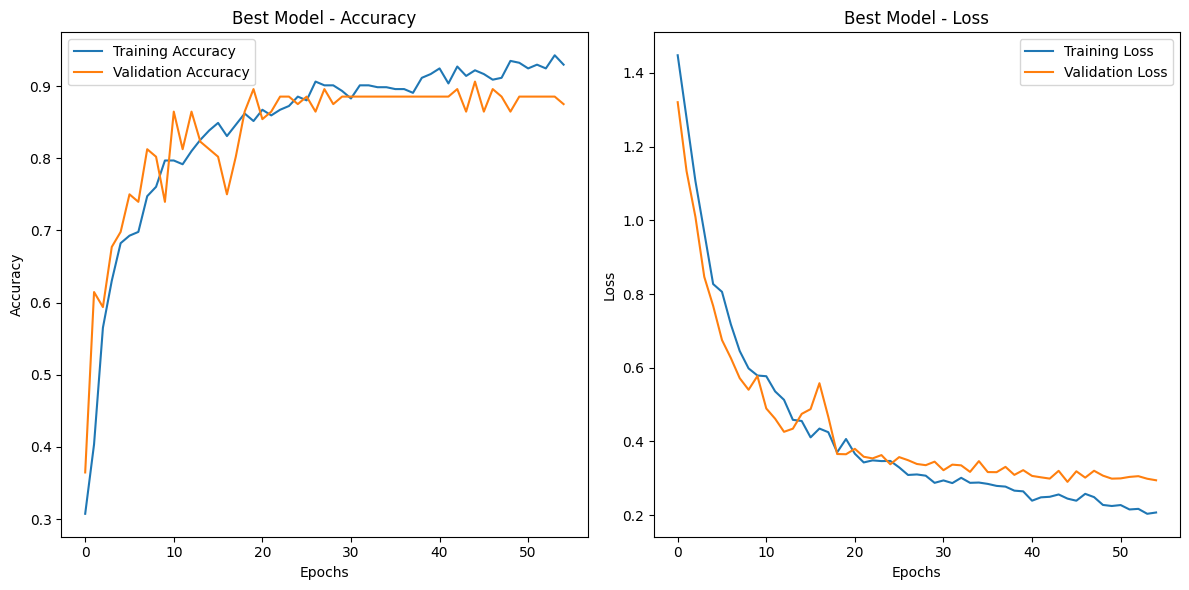

In [8]:
plot_history(best_history, "Best Model")

### Evaluation on Dataset 9

In [19]:
# Evaluate the best model on the entire dataset
data_gen.reset()
Y_pred = best_model.predict(data_gen)
y_pred = tf.argmax(Y_pred, axis=1).numpy()
y_true = data_gen.classes

# Generate classification report
report = classification_report(y_true, y_pred, target_names=list(data_gen.class_indices.keys()))
print(report)

15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
              precision    recall  f1-score   support

      glioma       0.93      0.93      0.93       120
  meningioma       0.87      0.82      0.84       120
     notumor       0.96      0.93      0.94       120
   pituitary       0.90      0.98      0.94       120

    accuracy                           0.91       480
   macro avg       0.91      0.91      0.91       480
weighted avg       0.91      0.91      0.91       480



### Generate confusion matrix

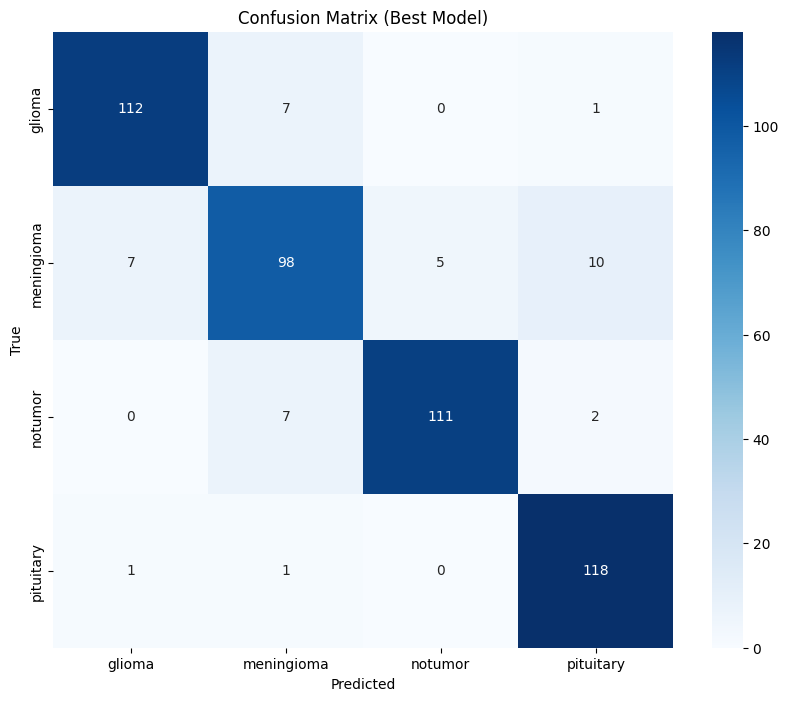

Accuracy on the entire dataset: 0.9146


In [20]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(data_gen.class_indices.keys()), yticklabels=list(data_gen.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Best Model)')
plt.show()

# Calculate and print accuracy
accuracy = accuracy_score(y_pred, y_true)
print(f'Accuracy on the entire dataset: {accuracy:.4f}')


### Assesment on combined dataset

In [23]:
testgen = ImageDataGenerator(
    rescale=1./255,
)
test_dir = 'final_dataset'
# Use the entire dataset without validation split
testgen_generator = testgen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure the order of predictions matches the order of labels
)
testgen_generator.reset()
predictions = best_model.predict(testgen_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = testgen_generator.classes
class_labels = list(testgen_generator.class_indices.keys())



Found 2896 images belonging to 4 classes.


c:\Users\TanYi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step


              precision    recall  f1-score   support

      glioma       0.87      0.89      0.88       703
  meningioma       0.80      0.76      0.78       773
     notumor       0.92      0.84      0.88       704
   pituitary       0.85      0.96      0.90       716

    accuracy                           0.86      2896
   macro avg       0.86      0.86      0.86      2896
weighted avg       0.86      0.86      0.86      2896



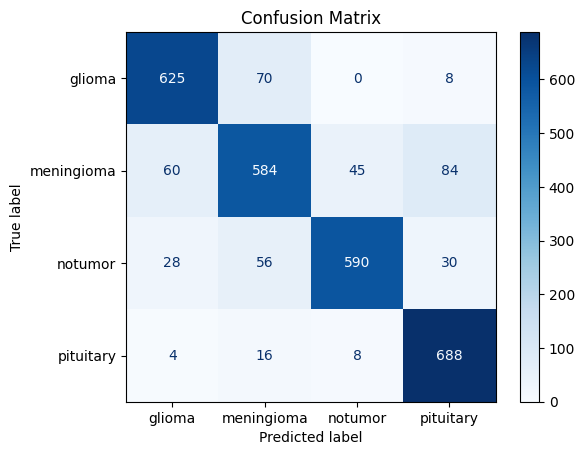

Accuracy on the entire dataset: 0.8588


In [24]:
# Generate classification report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
report = classification_report(true_classes, predicted_classes, target_names=list(testgen_generator.class_indices.keys()))
print(report)


# Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calculate and print accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Accuracy on the entire dataset: {accuracy:.4f}')

### Making Predictions

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
C:\Users\TanYi\AppData\Local\Temp\ipykernel_4632\814498286.py:10: SyntaxWarning: invalid escape sequence '\m'
  img_path = 'dataset_9\meningioma\Te-me_0106.jpg'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
Predicted class: meningioma


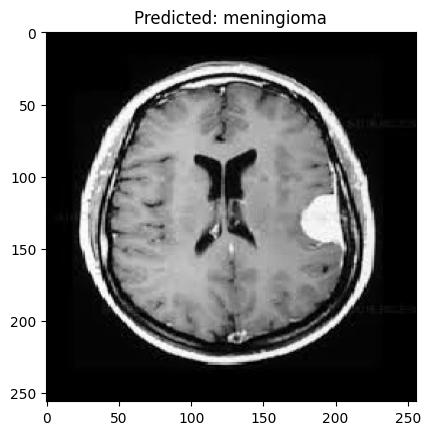

In [31]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the model
model = load_model('T09_VGG16.h5')

# Load and preprocess the image
img_path = 'dataset_9\meningioma\Te-me_0106.jpg'  
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Rescale the image

# Make prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# If you have the class labels from your training data
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']  
predicted_label = class_labels[predicted_class[0]]

# Print the prediction
print(f'Predicted class: {predicted_label}')

# Display image with prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_label}')
plt.show()
